# Using TensorFlow for classification on a cat/dog dataset using mobilenetv2 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Downloading the Traning and validation data set

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## Visualizing data

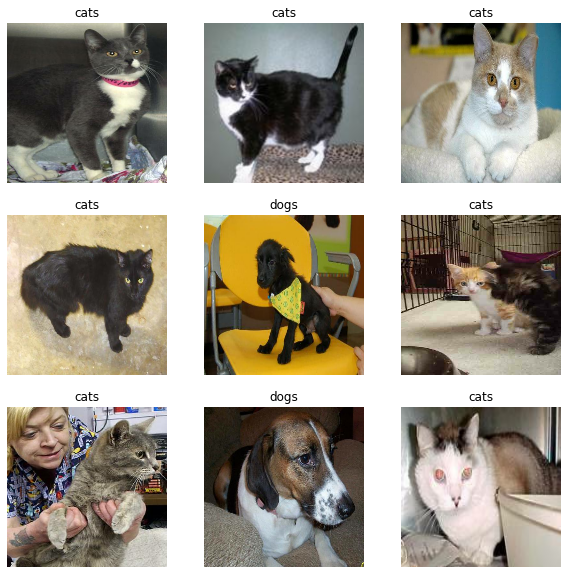

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Creation of test Dataset

In [ ]:
# Create a test set from the 20% of the validation set

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

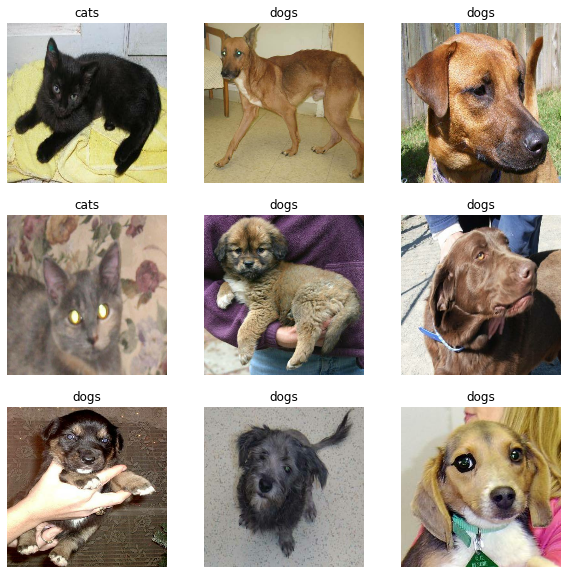

In [ ]:
# Visualize the test data

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Configure the dataset for performance

In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking. 

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [ ]:
# Create Data augmentations

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

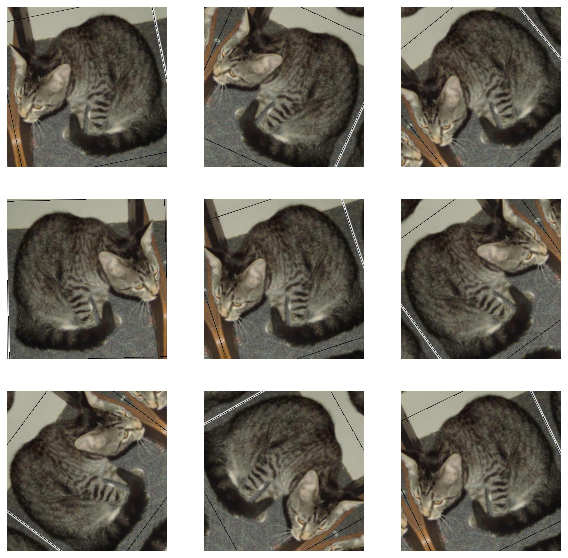

In [ ]:
# Visualiztion of data augmentation
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Rescale colors to be between [-1,1] instead of [0, 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Download pretrained model (**MobileNetV2**)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
# Freezing the convolutional base
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Adding layers to the pretrained model

In [ ]:
# Add a classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
# Adding dense layer to convert images into predictions.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Ensembling the model

In [ ]:
'''
Chaining together the data augmentation, rescaling, base_model 
and feature extractor layers.
'''

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
'''
Compile the model before training it. 
binary cross-entropy loss with from_logits=True for 2 classes
'''

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Observe the trainable parameters

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

## Training the model

In [ ]:
# Use the validation set for a look on accuracy without training

initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print(f"initial loss: {loss0}")
print(f"initial accuracy: {accuracy0}")

26/26 [==============================] - 15s 562ms/step - loss: 0.8661 - accuracy: 0.5074


initial loss: 0.87
initial accuracy: 0.51


In [ ]:
# Training the model

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 59s 935ms/step - loss: 0.7349 - accuracy: 0.5720 - val_loss: 0.5559 - val_accuracy: 0.6572
Epoch 2/10
63/63 [==============================] - 59s 940ms/step - loss: 0.5350 - accuracy: 0.6925 - val_loss: 0.4063 - val_accuracy: 0.7859
Epoch 3/10
63/63 [==============================] - 59s 943ms/step - loss: 0.4250 - accuracy: 0.7630 - val_loss: 0.3139 - val_accuracy: 0.8552
Epoch 4/10
63/63 [==============================] - 59s 943ms/step - loss: 0.3690 - accuracy: 0.8115 - val_loss: 0.2594 - val_accuracy: 0.9022
Epoch 5/10
63/63 [==============================] - 59s 939ms/step - loss: 0.3248 - accuracy: 0.8395 - val_loss: 0.2214 - val_accuracy: 0.9220
Epoch 6/10
63/63 [==============================] - 60s 945ms/step - loss: 0.2804 - accuracy: 0.8750 - val_loss: 0.1917 - val_accuracy: 0.9344
Epoch 7/10
63/63 [==============================] - 60s 945ms/step - loss: 0.2744 - accuracy: 0.8740 - val_loss: 0.1734 - val_accuracy: 0.9418

## Results after training

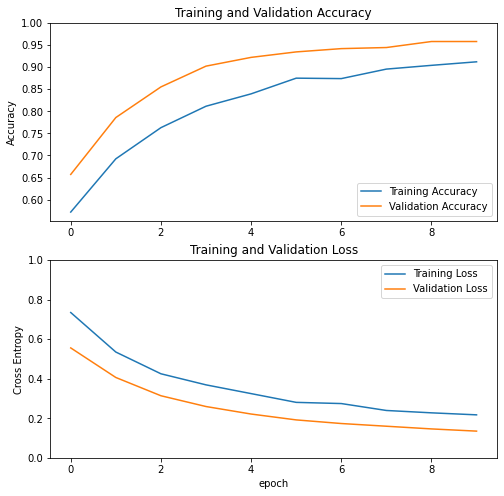

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

loss1, accuracy1 = model.evaluate(validation_dataset)
print(f"initial loss: {loss1}")
print(f"initial accuracy: {accuracy1}")

## Fine Tuning

In [ ]:
# Unfreezing the base model

base_model.trainable = True

# Let's take a look to see how many layers are in the base model

print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# Fine-tune from this layer onwards

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
# Recompile the model and use a 10th of the learning rate (to avoid overfitting)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

## Train model after fine tunning

In [ ]:
# If the model trained to convergence 
# this will improve the accuracy

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 91s 1s/step - loss: 0.1698 - accuracy: 0.9310 - val_loss: 0.0683 - val_accuracy: 0.9691
Epoch 11/20
63/63 [==============================] - 90s 1s/step - loss: 0.1289 - accuracy: 0.9465 - val_loss: 0.0801 - val_accuracy: 0.9765
Epoch 12/20
63/63 [==============================] - 89s 1s/step - loss: 0.1030 - accuracy: 0.9555 - val_loss: 0.0518 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 89s 1s/step - loss: 0.0961 - accuracy: 0.9615 - val_loss: 0.0460 - val_accuracy: 0.9777
Epoch 14/20
63/63 [==============================] - 88s 1s/step - loss: 0.0963 - accuracy: 0.9610 - val_loss: 0.0441 - val_accuracy: 0.9777
Epoch 15/20
63/63 [==============================] - 87s 1s/step - loss: 0.0878 - accuracy: 0.9640 - val_loss: 0.0443 - val_accuracy: 0.9802
Epoch 16/20
63/63 [==============================] - 87s 1s/step - loss: 0.0807 - accuracy: 0.9655 - val_loss: 0.0502 - val_accuracy: 0.9851
Epoch 17/20
6

## Results after Fine tunning

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

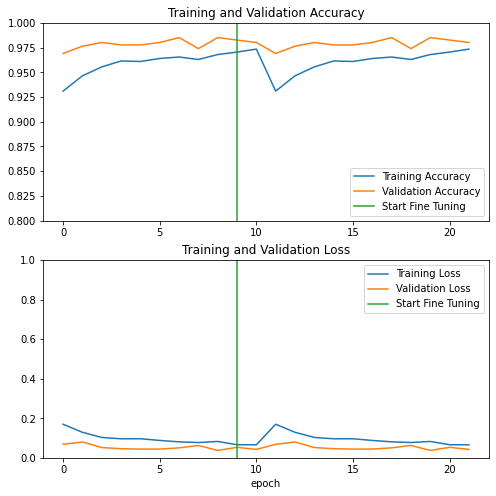

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 490ms/step - loss: 0.0412 - accuracy: 0.9844
Test accuracy : 0.984375


## Make random prediction

Predictions:
 [0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0]
Labels:
 [0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0]


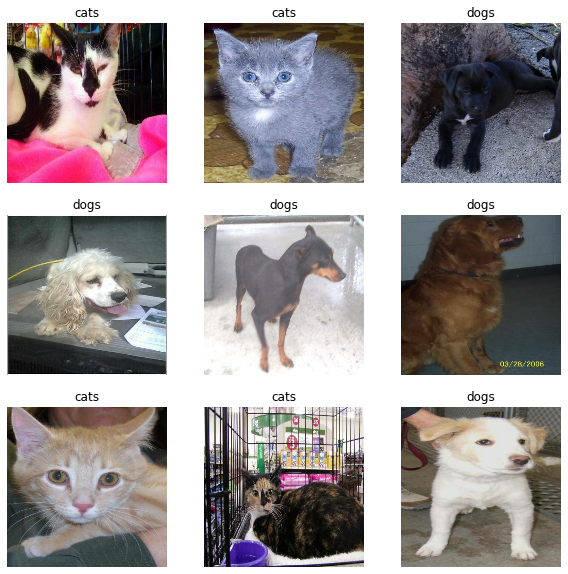

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")